## Implementation of Artificial Neural Networks on People's Analytics Project


### Introduction

This work is an extension of the machine learning project on people's analytics dataset. In the last work tree based methods were implementted to accomplish two objectives:

+ A binary classification to predict GHC’s Round 3 semifinalist Designation (whether an applicant qualifies as semifinalist or not).
+ The importance of various features that effect Round3 reviewer’s semifinalist designation decision.

The tree based methods generated features importance that helped in interpreting the contribution made by each feature. The project was taken to the next level by implementation on artificial neural networks on top of the tree based methods. After data cleaning and feature engineering step 109 features were generated.

25% of those input features with higher feature importance were selected from the original dataset and were fed into a multi layer perceptron model. Later, the model was tuned further to generate the most optimized solution.


#### Tools used :
+ Numpy, Pandas
+ Sklearn, Keras, tensorflow
+ Seaborn, matplotlib


The performance of the predictive models have been measured using Area Under ROC Curve which evaluates the goodness of the classification model and accuracy of classification.




In [2]:
# Import the libraries
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from keras.layers import Dropout

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


### Data Preprocessing

As metioned earlier in machine learning part of thr project, the entire data mining operation for this work has been performed in a separate notebook https://github.com/shrutisingh15/Journal-Entries/blob/master/DataPreparation.ipynb

The cleaned data was saved into a csv file for later usage.

In [69]:
# Load the cleaned up data
df = pd.read_csv('PeopleAnalyticsCleandata.csv',header=0)
# drop the irrelevant columns
df.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1,inplace=True)

In [70]:
# Take a quick look at the cleaned data
df.head()

,American Indian,Asian,Black,Hispanic,Hawaiian,White,Other Race,Sex,Have you previously applied?,Round2 Reviews Plagirism Reviewer1,...,firstLanguage_Tigrigna,firstLanguage_Tonga,firstLanguage_Urdu,firstLanguage_Vietnamese,Advanced/Full Professional Proficiency,Basic Proficiency,Fluent/Native Speaker,Limited working proficiency,Professional working proficiency,SemifinalistDesignation
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


Let's make sure no missing are present in the dataset...

In [71]:
# check that all nulls are removed
df.isnull().sum().sum()

0

### Feature Selection

The implementation of tree based methods generated importance of various input features and since the optimzed tree based solution gave the best model performance with 25% of the features. So, top 25% of the input variables will be used for fitting the neural network in this part.


Let's a look at the features importance prior to the feature selection and model fitting.

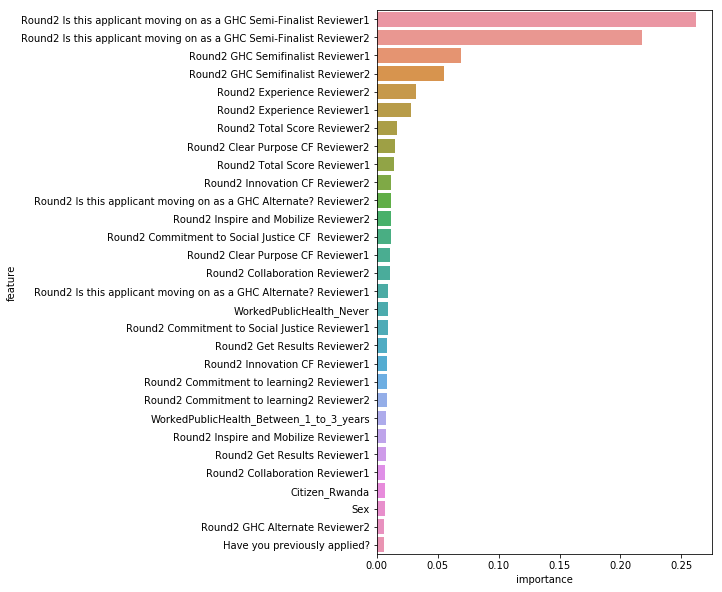

In [23]:
fImp=pd.read_csv('featureImp.csv')
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplots(figsize=(6,10))

dt = fImp.head(30)
sns.barplot(x='importance',y='feature',data=dt)

From the above data, it looks like Round2 Reviewer's scores make a significant impact on the decision on whether the candidate should move to the semifinalist round.

From the above results it becomes clear that Round2 Reviewers opinion about candidates profile really play a significant role in a candidate's selection as a semifinalist.

The features importances generated by the final model makes it very clear that both Reviewer1 and Reviewer2's decision on whether the applicant should move to semifinal round is extremely important.Other very important features to consider are:
+ whether the applicant demonstrates past experience in that specific position.
+ whether the applicant demonstrates clear sense of purpose for joining GHC community.
+ innovativeness of the applicant.
+ whether the applicant has the potential to inspire and mobilize other i.e his leadership skills.
+ whether the applicant demonstrates any commitment to social justice.
+ whether the applicant demonstrates any value of collaboration i.e will he/she prove to be a good team player etc...


So, in the next section these relevant features are selected and multilayer perceptron model is fitted.

In [92]:
# select the first 29 high features importance features that constitude 25% of the total input features.
features=fImp.loc[0:29,:]['feature'].values

# Input features
X = df.drop('SemifinalistDesignation',axis=1)
X = X[features]

# target variable : binary value
y = df['SemifinalistDesignation']

# perform train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,stratify=y)

print "No. of features which constitute 25% of original features space: ", X.shape[1]

print "no. of rows and columns for model training: ", X_train.shape
print "no. of rows and columns for model evaluation: ", X_test.shape

No. of features which constitute 25% of original features space:  30
no. of rows and columns for model training:  (3448, 30)
no. of rows and columns for model evaluation:  (609, 30)


In [93]:
# take a look at the input space
X_train.head()

,Round2 Is this applicant moving on as a GHC Semi-Finalist Reviewer1,Round2 Is this applicant moving on as a GHC Semi-Finalist Reviewer2,Round2 GHC Semifinalist Reviewer1,Round2 GHC Semifinalist Reviewer2,Round2 Experience Reviewer2,Round2 Experience Reviewer1,Round2 Total Score Reviewer2,Round2 Clear Purpose CF Reviewer2,Round2 Total Score Reviewer1,Round2 Innovation CF Reviewer2,...,Round2 Commitment to learning2 Reviewer1,Round2 Commitment to learning2 Reviewer2,WorkedPublicHealth_Between_1_to_3_years,Round2 Inspire and Mobilize Reviewer1,Round2 Get Results Reviewer1,Round2 Collaboration Reviewer1,Citizen_Rwanda,Sex,Round2 GHC Alternate Reviewer2,Have you previously applied?
837,1,1,9.0,10.0,3.0,3.0,18.0,3.0,26.0,3.0,...,3.0,3.0,0.0,3.0,4.0,3.0,0.0,1.0,0.0,0.0
1425,1,0,6.0,0.0,2.0,3.0,16.0,3.0,22.0,2.0,...,3.0,3.0,0.0,0.0,3.0,3.0,0.0,1.0,0.0,0.0
1812,1,0,9.0,0.0,3.0,3.0,23.0,3.0,27.0,3.0,...,4.0,4.0,0.0,3.0,3.0,4.0,0.0,1.0,1.0,0.0
1686,1,0,4.0,0.0,3.0,3.0,26.0,4.0,24.0,3.0,...,3.0,3.0,1.0,2.0,3.0,3.0,0.0,1.0,0.0,0.0
3384,0,0,0.0,0.0,3.0,2.0,19.0,2.0,23.0,3.0,...,3.0,2.0,1.0,3.0,3.0,3.0,0.0,1.0,0.0,0.0


In [94]:
# And outout variable
y_train.head()

837     1.0
1425    0.0
1812    0.0
1686    0.0
3384    0.0
Name: SemifinalistDesignation, dtype: float64

### Data Normalization

Before feeding the data into the network, let's normalize the data between 0 and 1. The reason behind this is that the network training will be started with sigmoid activation function and for sigmoid function it is appropriate to tranform the data between 0 and 1.

In [95]:
# Normalize the data...
mmx = MinMaxScaler(feature_range=(0,1))
mmy = MinMaxScaler(feature_range=(0,1))

X_train = mmx.fit_transform(X_train.values)
X_test = mmx.transform(X_test.values)
y_train= mmy.fit_transform(y_train.reshape(-1,1))
y_test = mmy.transform(y_test.reshape(-1,1))

In [101]:
print "Input feature space after normalization: \n\n", X_train


Input feature space after normalization: 

[[1.  1.  0.9 ... 1.  0.  0. ]
 [1.  0.  0.6 ... 1.  0.  0. ]
 [1.  0.  0.9 ... 1.  0.2 0. ]
 ...
 [1.  0.  1.  ... 1.  0.  1. ]
 [0.  1.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 1.  0.  1. ]]


### Multilayer Perceptron Network:

Starting with the base line model with the following network configurations....

#### Tuning the no. of epochs parameter: 

No. of Epochs considered :

+ 100
+ 200
+ 250


Best results were obtained with 250 epochs and batch size of 10.


In [110]:
#Set the seed
seed = 7
np.random.seed(seed)


epochs = 200   # epochs
batch = 10     # batch size

# Function to define initial network architecture
def create_model(inputSpace=30,neuron1H=10,neuronO=1,weights='normal',actFunc='sigmoid',optimizer='adam'):
    model = Sequential()
    model.add(Dense(neuron1H, input_dim=inputSpace, kernel_initializer=weights, activation=actFunc))
    model.add(Dense(neuronO, kernel_initializer=weights, activation=actFunc))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Wrap the model in keras classifier
estimator = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size= batch, verbose=0)
# Perform stratified  kfold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Results: %.2f%% mean accuracy with (%.2f%%) variance" % (results.mean()*100, results.std()*100))

Results: 86.66% mean accuracy with (1.64%) variance


The baseline model gave 86.6% accuracy with 1.64% variance. Let's tune the no. of epochs to get the optimal solution.

In [13]:
# changed epochs to 200 

epochs = 200   # epochs
batch = 10     # batch size

def create_model(inputSpace=30,neuron1H=10,neuronO=1,weights='normal',actFunc='sigmoid',optimizer='adam'):
    model = Sequential()
    model.add(Dense(neuron1H, input_dim=inputSpace, kernel_initializer=weights, activation=actFunc))
    model.add(Dense(neuronO, kernel_initializer=weights, activation=actFunc))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


# Fit the model
estimator = KerasClassifier(build_fn=create_baseline, epochs=epochs, batch_size=batch, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Results: %.2f%% mean accuracy with (%.2f%%) variance" % (results.mean()*100, results.std()*100))

Results: 86.60% mean accuracy with (2.04%) variance


200 epochs gave almost similar accuracy but higher variance. This is a sign of overfitting. Let's tune the no. of epochs further....

In [14]:
# changed epochs to 250 
epochs = 250   # epochs
batch = 10     # batch size

def create_model(inputSpace=30,neuron1H=10,neuronO=1,weights='normal',actFunc='sigmoid',optimizer='adam'):
    model = Sequential()
    model.add(Dense(neuron1H, input_dim=inputSpace, kernel_initializer=weights, activation=actFunc))
    model.add(Dense(neuronO, kernel_initializer=weights, activation=actFunc))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


# Start base line
estimator = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Results: %.2f%% mean accuracy with (%.2f%%) variance" % (results.mean()*100, results.std()*100))

Results: 86.02% mean accuracy with (0.97%) variance


The variance decreased with 250 epochs. Hence, 250 epochs is being used for further tuning other parameters.

#### Tuning Weight Initialization parameter:

Weight Initialization parameters:
+ Normal 
+ Uniform

Best Results were obtained with Normal distribution.

In [15]:
# changed weight initialization to uniform

epochs = 250   # epochs
batch = 10     # batch size

def create_model(inputSpace=30,neuron1H=10,neuronO=1,weights='uniform',actFunc='sigmoid',optimizer='adam'):
    model = Sequential()
    model.add(Dense(neuron1H, input_dim=inputSpace, kernel_initializer=weights, activation=actFunc))
    model.add(Dense(neuronO, kernel_initializer=weights, activation=actFunc))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


estimator = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Results: %.2f%% mean accuracy with (%.2f%%) variance" % (results.mean()*100, results.std()*100))

Results: 85.76% mean accuracy with (0.85%) variance


The accuracy has decreased with uniform weight initialization method. So, normal weight initialization will be used for further tuning. 

#### Tuning the activation function parameter:

Activation functions parameters:  
+ Sigmoid activation function
+ Rectifier activation function

Best results were obtained with Sigmoid Activation function.


In [16]:
# changed weight initialization back to normal and switched to rectifier activation function in 1st hidden layer

epochs = 250   # epochs
batch = 10     # batch size

def create_model(inputSpace=30,neuron1H=10,neuronO=1,weights='normal',actFunc1='relu',actFunc2='sigmoid',optimizer='adam'):
    model = Sequential()
    model.add(Dense(neuron1H, input_dim=inputSpace, kernel_initializer=weights, activation=actFunc1))
    model.add(Dense(neuronO, kernel_initializer=weights, activation=actFunc2))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


# Start base line
estimator = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Results: %.2f%% mean accuracy with (%.2f%%) variance" % (results.mean()*100, results.std()*100))

Results: 85.67% mean accuracy with (0.98%) variance


Accuracy decreased and variance increased with rectifier activation function in the 1st hidden layer. So, sigmoid activation function was used for further tuning.

#### Tuning the no. of neurons and no. of hidden layers:

+ 1 hidden layer with 30 neurons.
+ 2 hidden layers with 30 and 20 neurons respectively.
+ 2 hidden layer with 30 and 10 neurons respectively.


Best results were obtained with two hidden layers with 30 and 10 neurons respectively.

In [18]:
# changed activation function back to sigmoid in 1st hidden layer and increased the no. of neurons in the 1st hidden layer to 30.

epochs = 250   # epochs
batch = 10     # batch size

def create_model(inputSpace=30,neuron1H=30,neuronO=1,weights='normal',actFunc='sigmoid',optimizer='adam'):
    model = Sequential()
    model.add(Dense(neuron1H, input_dim=inputSpace, kernel_initializer=weights, activation=actFunc))
    model.add(Dense(neuronO, kernel_initializer=weights, activation=actFunc))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Results: %.2f%% mean accuracy with (%.2f%%) variance" % (results.mean()*100, results.std()*100))

Results: 86.28% mean accuracy with (1.00%) variance


Accuracy increased further but variance did too. Increasing variance is a sign of overfitting. So, let's add another hidden layer with 20 neurons.

In [20]:
# added another hidden layer with 20 neurons
epochs = 250   # epochs
batch = 10     # batch size

def create_model(inputSpace=30,neuron1H=30,neuron2H=20,neuronO=1,weights='normal',actFunc='sigmoid',optimizer='adam'):
    model = Sequential()
    model.add(Dense(neuron1H, input_dim=inputSpace, kernel_initializer=weights, activation=actFunc))
    model.add(Dense(neuron2H,kernel_initializer=weights,activation=actFunc))
    model.add(Dense(neuronO, kernel_initializer=weights, activation=actFunc))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Start base line
estimator = KerasClassifier(build_fn=create_model, epochs=250, batch_size=10, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Results: %.2f%% mean accuracy with (%.2f%%) variance" % (results.mean()*100, results.std()*100))

Results: 85.64% mean accuracy with (1.06%) variance


The performance degraded further...Let's cut the no. of neurons to 10 in the second hidden layer.

In [22]:
# changed the no. of neurons in the second hidden layer to 10

epochs = 250   # epochs
batch = 10     # batch size

def create_model(inputSpace=30,neuron1H=30,neuron2H=10,neuronO=1,weights='normal',actFunc='sigmoid',optimizer='adam'):
    model = Sequential()
    model.add(Dense(neuron1H, input_dim=inputSpace, kernel_initializer=weights, activation=actFunc))
    model.add(Dense(neuron2H,kernel_initializer=weights,activation=actFunc))
    model.add(Dense(neuronO, kernel_initializer=weights, activation=actFunc))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Start base line
estimator = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Results: %.2f%% mean accuracy with (%.2f%%) variance" % (results.mean()*100, results.std()*100))

Results: 85.82% mean accuracy with (0.86%) variance


Variance decreased with 30 and 10 neurons in the 1st and 2nd hidden layer respectively. So, this configuration was used for further tuning.

#### Tuned Dropout Regularization parameter:

+ 0.01 Dropout in both the hidden layers.
+ 0.01 Dropout in the first hidden layer.

Best results were obtained with 0.01 regularization i.e dropping 1% of the neurons from the 1st hidden layer.

In [14]:
# added dropout regularization after 1st hidden layer

epochs = 250   # epochs
batch = 10     # batch size

def create_model(inputSpace=30,neuron1H=30,neuron2H=10,neuronO=1,weights='normal',actFunc='sigmoid',optimizer='adam',dropout=0.01):
    model = Sequential()
    model.add(Dense(neuron1H, input_dim=inputSpace, kernel_initializer=weights, activation=actFunc))
    model.add(Dropout(dropout))
    model.add(Dense(neuron2H,kernel_initializer=weights,activation=actFunc))
    model.add(Dense(neuronO, kernel_initializer=weights, activation=actFunc))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


estimator = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Results: %.2f%% mean accuracy with (%.2f%%) variance" % (results.mean()*100, results.std()*100))

Results: 86.72% mean accuracy with (0.23%) variance


In [15]:
# added dropout regularization after both 1st and 2nd hidden layers.

epochs = 250   # epochs
batch = 10     # batch size

def create_model(inputSpace=30,neuron1H=30,neuron2H=10,neuronO=1,weights='normal',actFunc='sigmoid',optimizer='adam',dropout=0.01):
    model = Sequential()
    model.add(Dense(neuron1H, input_dim=inputSpace, kernel_initializer=weights, activation=actFunc))
    model.add(Dropout(dropout))
    model.add(Dense(neuron2H,kernel_initializer=weights,activation=actFunc))
    model.add(Dropout(dropout))
    model.add(Dense(neuronO, kernel_initializer=weights, activation=actFunc))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Results: %.2f%% mean accuracy with (%.2f%%) variance" % (results.mean()*100, results.std()*100))

Results: 86.05% mean accuracy with (0.46%) variance


Best performance was observed with 0.01 i.e.by randomly dropping 1% of the neurons from just the 1st hidden layer. So, this configuration was used for further tuning.

#### Tuning the Learning Algorithm parameter:

+ Adam
+ SGD
+ Adagrad
+ RMSprop

After experimenting with the above tuning parameters, the final notework was fit with the following network configuration to study the effect of the above specified learning algorithms.

+ No. of epochs : 250 , batch size : 10
+ Weight Initialization : Normal distribution
+ Activation Function : Sigmoid
+ 2 Hidden layers: (1st hidden layer: 30 neurons and 2nd hidden layer: 10 neurons).
+ Dropout Regularization (Dropped 1% of neurons from the 1st hidden layer).

The following results were obtained with all of the optimizers on training and testing datasets.

In [ ]:
epochs = 250   # epochs
batch = 10     # batch size

def create_model(inputSpace=30,neuron1H=30,neuron2H=10,neuronO=1,weights='normal',actFunc='sigmoid',optimizer=opt,dropout=0.01):
    model = Sequential()
    model.add(Dense(neuron1H, input_dim=inputSpace, kernel_initializer=weights, activation=actFunc))
    model.add(Dropout(dropout))
    model.add(Dense(neuron2H,kernel_initializer=weights,activation=actFunc))
    model.add(Dense(neuronO, kernel_initializer=weights, activation=actFunc))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch, verbose=0)
#opt ='adam'
#historyadam=estimator.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochs,batch_size=batch,verbose=0)
#opt = 'SGD'
#historysgd=estimator.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochs,batch_size=batch,verbose=0)
#opt ='RMSprop'
#historyRMS=estimator.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochs,batch_size=batch,verbose=0)
opt ='Adagrad'
historyAdagrad=estimator.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochs,batch_size=batch,verbose=0)


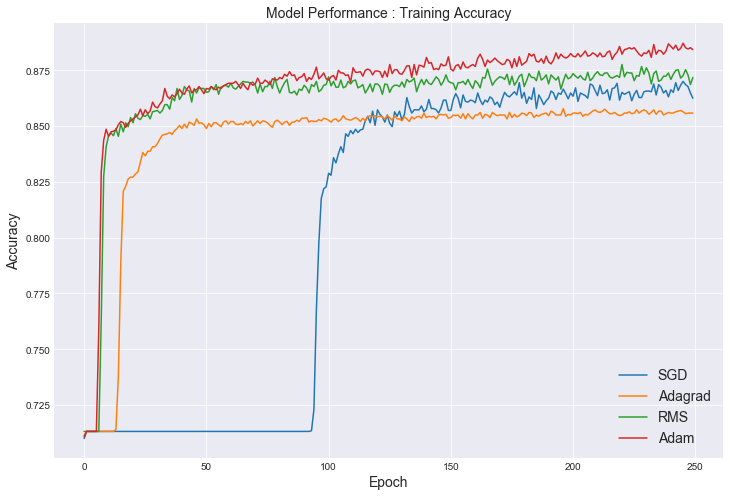

In [25]:
# Visualize the effect of various learning algorithms on model performance of training set
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
plt.plot(historysgd.history['acc'])
plt.plot(historyAdagrad.history['acc'])
plt.plot(historyRMS.history['acc'])
plt.plot(historyadam.history['acc'])
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.title('Model Performance : Training Accuracy',fontsize=14)
plt.legend(['SGD', 'Adagrad','RMS','Adam'], loc='lower right',fontsize=14)

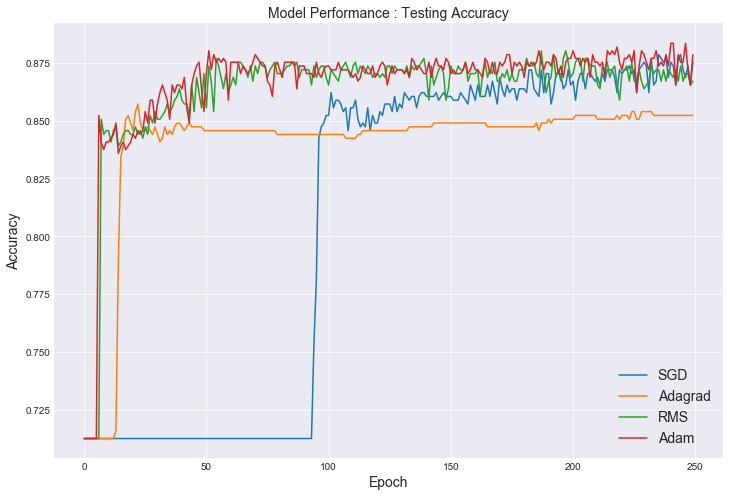

In [33]:
# Visualize the effect of various learning algorithms on model performance of training set
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
plt.plot(historysgd.history['val_acc'])
plt.plot(historyAdagrad.history['val_acc'])
plt.plot(historyRMS.history['val_acc'])
plt.plot(historyadam.history['val_acc'])
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.title('Model Performance : Testing Accuracy',fontsize=14)
plt.legend(['SGD', 'Adagrad','RMS','Adam'], loc='lower right',fontsize=14)

From the above graphs it becomes apparent that adaptive learning based algorithms like Adam, RMsprop and Adagrad perform better than classical SGD. The learning rate in SGD is very slow. Adam optimizer gave the best results. 

Hence, Adam optimizer was choosen as the final learning algorithm.

Area Under ROC curve with 30 features on Neural Nets was: 0.8413364055299539
Final Accuracy received on test set was : 0.8686371031653117


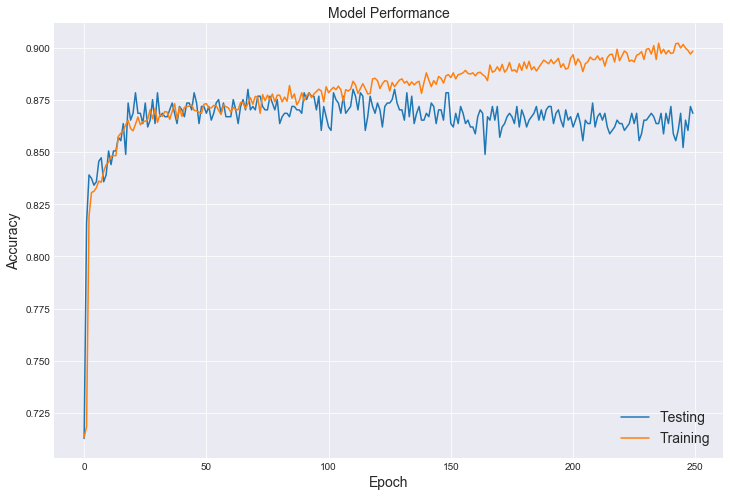

In [65]:
epochs = 250   # epochs
batch = 10     # batch size

def create_model(inputSpace=30,neuron1H=30,neuron2H=10,neuronO=1,weights='normal',actFunc='sigmoid',optimizer='adam',dropout=0.01):
    model = Sequential()
    model.add(Dense(neuron1H, input_dim=inputSpace, kernel_initializer=weights, activation=actFunc))
    model.add(Dropout(dropout))
    model.add(Dense(neuron2H,kernel_initializer=weights,activation=actFunc))
    model.add(Dense(neuronO, kernel_initializer=weights, activation=actFunc))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch, verbose=0)

history=estimator.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochs,batch_size=batch,verbose=0)

from sklearn.metrics import roc_auc_score

print "Area Under ROC curve with 30 features on Neural Nets was:",roc_auc_score(y_test,estimator.predict(X_test))
print "Final Accuracy received on test set was :", history.history['val_acc'][-1]

# Plot the final model performance
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
plt.plot(history.history['val_acc'])
plt.plot(history.history['acc'])
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.title('Model Performance',fontsize=14)
plt.legend(['Testing','Training'], loc='lower right',fontsize=14)
plt.show()

The best network predicted if the candidates who applied to GHC were selected for semifinalist round or not with 86% accuracy. Further more, as the target variable (i.e the proportion of candidates selected and not selected for semifinals was not equal in the dataset) it becomes very important to consider the area under roc curve to evaluate the model. The value obtained was 0.841 which confirms the goodness of the model.

+ No. of epochs : 250 , batch size : 10
+ Weight Initialization : Normal distribution
+ Activation Function : Sigmoid
+ 2 Hidden layers: (1st hidden layer: 30 neurons and 2nd hidden layer: 10 neurons).
+ Dropout Regularization (Dropped 1% of neurons from the 1st hidden layer).
+ Adam optimizer.


### Discussion:

In the overall People's Analytics Project on the data set provided by Wharton's Case Competition, 109 features were generated after the data cleaning operation. In the 1s part of the project, tree based machine learning methods were used to undertand the contribution of various factors that impact that result, whether a candidate who has applied to Global Health Corps will be selected for semifinals or not. In the second part of the project a subset of the features were selected depending on their importance to fit an artificial neural network using multilayer perceptron to perform the actual binary classification.

As mentioned in data preprocessing steps, only 25% of the features were selected for network fitting. 

This work can further be extended by selecting more or less features using forward/backward feature selection techniques. Also, there is a lot of scope of fine tuning the network configuration parameters further to generate a more robust model that can help Global Health Corps optimize their application review process.


### References: 

+ Data Source : https://wpa.wharton.upenn.edu/conference/2018-conference-competitions
+ Global Health Corps: https://ghcorps.org/
+ Neural Nets: https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/
+ Machine Learning: http://scikit-learn.org/





